## Import Packages

In [2]:
# import the necessary packages
from tensorflow.keras.applications import resnet
from imutils.paths import list_images
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import random
import cv2
import os

## Prepare face dataset

In [3]:
train_args = {
	"dataset": "dataset/train_dataset",
	"output": "dataset/cropped_train_dataset",
}

test_args = {
	"dataset": "dataset/test_dataset",
	"output": "dataset/cropped_test_dataset",
}

args = {
	"prototxt": "dataset/face_crop_model/deploy.prototxt.txt",
	"model": "dataset/face_crop_model/res10_300x300_ssd_iter_140000.caffemodel",
	"confidence": 0.5,
}

In [3]:
# load our serialized model from disk
print("[INFO] loading model...")
net = cv2.dnn.readNetFromCaffe(args["prototxt"], args["model"])
print("[INFO] model loaded")

[INFO] loading model...
[INFO] model loaded


In [ ]:
for arguments in [train_args, test_args]:
    # check if the output dataset directory exists, if it doesn't, then
    # create it
    if not os.path.exists(arguments["output"]):
        print(f"[INFO] creating {arguments['output']}...")
        os.makedirs(arguments["output"])

    # grab the file and sub-directory names in dataset directory
    print(f"[INFO] grabbing the names of files and directories from {arguments['dataset']}...")
    names = os.listdir(arguments["dataset"])

    # loop over all names
    print("[INFO] starting to crop faces and saving them to disk...")
    for name in tqdm(names):
        # build directory path
        dirPath = os.path.join(arguments["dataset"], name)

        # check if the directory path is a directory
        if os.path.isdir(dirPath):
            # grab the path to all the images in the directory
            imagePaths = list(list_images(dirPath))

            # build the path to the output directory
            outputDir = os.path.join(arguments["output"], name)

            # check if the output directory exists, if it doesn't, then
            # create it
            if not os.path.exists(outputDir):
                os.makedirs(outputDir)

            # loop over all image paths
            for imagePath in imagePaths:
                # grab the image ID, load the image, and grab the
                # dimensions of the image
                imageID = imagePath.split(os.path.sep)[-1]
                image = cv2.imread(imagePath)
                (h, w) = image.shape[:2]

                # construct an input blob for the image by resizing to a
                # fixed 300x300 pixels and then normalizing it
                blob = cv2.dnn.blobFromImage(cv2.resize(image,
                    (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

                # pass the blob through the network and obtain the
                # detections and predictions
                net.setInput(blob)
                detections = net.forward()

                # extract the index of the detection with max 
                # probability and get the maximum confidence value
                i = np.argmax(detections[0, 0, :, 2])
                confidence = detections[0, 0, i, 2]

                # filter out weak detections by ensuring the 
                # `confidence` is greater than the minimum confidence
                if confidence > args["confidence"]:
                    # grab the maximum dimension value
                    maxDim = np.max(detections[0, 0, i, 3:7])

                    # check if max dimension value is greater than one,
                    # if so, skip the detection since it is erroneous
                    if maxDim > 1.0:
                        continue

                    # clip the dimension values to be between 0 and 1
                    box = np.clip(detections[0, 0, i, 3:7], 0.0, 1.0)

                    # compute the (x, y)-coordinates of the bounding
                    # box for the object
                    box = box * np.array([w, h, w, h])
                    (startX, startY, endX, endY) = box.astype("int")
                
                    # grab the face from the image, build the path to
                    # the output face image, and write it to disk
                    face = image[startY:endY,startX:endX,:]
                    facePath = os.path.join(outputDir, imageID)
                    cv2.imwrite(facePath, face)

    print("[INFO] finished cropping faces and saving them to disk...")

[INFO] grabbing the names of files and directories from dataset/train_dataset...
[INFO] starting to crop faces and saving them to disk...


 77%|█████████████████████████████▉         | 4413/5749 [02:19<00:43, 30.87it/s]

## Load utility functions (for training only)

#### Config

In [3]:
class Config:
    # path to training and testing data
    TRAIN_DATASET = "dataset/cropped_train_dataset"
    TEST_DATASET = "dataset/cropped_test_dataset"

    # model input image size
    IMAGE_SIZE = (224, 224)

    # batch size and the buffer size
    BATCH_SIZE = 128
    BUFFER_SIZE = BATCH_SIZE * 2

    # define autotune
    AUTO = tf.data.AUTOTUNE

    # define the training parameters
    LEARNING_RATE = 0.0001
    STEPS_PER_EPOCH = 50
    VALIDATION_STEPS = 10
    EPOCHS = 50

    # define the path to save the model
    OUTPUT_PATH = "model"
    MODEL_PATH = os.path.join(OUTPUT_PATH, "saved_model")
    OUTPUT_IMAGE_PATH = os.path.join(OUTPUT_PATH, "output/output_image.png")

#### MapFunction

In [3]:
class MapFunction():
    def __init__(self, imageSize):
        # define the image width and height
        self.imageSize = imageSize

    def decode_and_resize(self, imagePath):
        # read and decode the image path
        image = tf.io.read_file(imagePath)
        image = tf.image.decode_jpeg(image, channels=3)

        # convert the image data type from uint8 to float32 and then resize
        # the image to the set image size
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        image = tf.image.resize(image, self.imageSize)

        # return the image
        return image
    
    def process_image(self, image):
        image_tensor = tf.convert_to_tensor(image)
        image_tensor = tf.expand_dims(image_tensor , 0)
        image_tensor = tf.image.convert_image_dtype(image_tensor, dtype=tf.float32)
        image_tensor = tf.image.resize(image_tensor, self.imageSize)
        
        # return the image
        return image_tensor

    def __call__(self, anchor, positive, negative):
        anchor = self.decode_and_resize(anchor)
        positive = self.decode_and_resize(positive)
        negative = self.decode_and_resize(negative)

        # return the anchor, positive and negative processed images
        return (anchor, positive, negative)

#### TripletGenerator

In [4]:
class TripletGenerator:
    def __init__(self, datasetPath):
        # create an empty list which will contain the subdirectory
        # names of the `dataset` directory with more than one image
        # in it
        self.peopleNames = list()

        # iterate over the subdirectories in the dataset directory
        for folderName in os.listdir(datasetPath):
            # build the subdirectory name
            absoluteFolderName = os.path.join(datasetPath, folderName)

            # get the number of images in the subdirectory
            numImages = len(os.listdir(absoluteFolderName))

            # if the number of images in the current subdirectory
            # is more than one, append into the `peopleNames` list
            if numImages > 1:
                self.peopleNames.append(absoluteFolderName)

        # create a dictionary of people name to thier image names
        self.allPeople = self.generate_all_people_dict()

    def generate_all_people_dict(self):
        # create an empty dictionary that will be populated with
        # directory names as keys and image names as values
        allPeople = dict()

        # iterate over all the directory names with more than one
        # image in it
        for personName in self.peopleNames:
            # get all the image names in the current directory
            imageNames = os.listdir(personName)

            # build the image paths and populate the dictionary
            personPhotos = [
                os.path.join(personName, imageName) for imageName in imageNames
            ]
            allPeople[personName] = personPhotos

        # return the dictionary
        return allPeople

    def get_next_element(self):
        # create an infinite generator
        while True:
            # draw a person at random which will be our anchor and
            # positive person
            anchorName = random.choice(self.peopleNames)

            # copy the list of people names and remove the anchor
            # from the list
            temporaryNames = self.peopleNames.copy()
            temporaryNames.remove(anchorName)

            # draw a person at random from the list of people without
            # the anchor, which will act as our negative sample
            negativeName = random.choice(temporaryNames)

            # draw two images from the anchor folder without replacement
            (anchorPhoto, positivePhoto) = np.random.choice(
                a=self.allPeople[anchorName],
                size=2,
                replace=False
            )

            # draw an image from the negative folder
            negativePhoto = random.choice(self.allPeople[negativeName])

            # yield the anchor, positive and negative photos
            yield (anchorPhoto, positivePhoto, negativePhoto)

## Load siamese model

In [10]:
# --> for GPU-only, try this to avoid warming messages
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# for device in gpu_devices:
#     tf.config.experimental.set_memory_growth(device, True)

In [7]:
from model.SiameseModel import SiameseModel
siamese_model = SiameseModel()

## Train siamese model

#### Initialize generators & mapper function

In [9]:
# create the data input pipeline for train and val dataset
config = Config()

trainTripletGenerator = TripletGenerator(datasetPath=config.TRAIN_DATASET)
valTripletGenerator = TripletGenerator(datasetPath=config.TRAIN_DATASET)

trainTfDataset = tf.data.Dataset.from_generator(
    generator=trainTripletGenerator.get_next_element,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.string),
    )
)
valTfDataset = tf.data.Dataset.from_generator(
    generator=valTripletGenerator.get_next_element,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.string),
    )
)

mapFunction = MapFunction(imageSize=config.IMAGE_SIZE)

trainDs = (trainTfDataset
    .map(mapFunction)
    .shuffle(config.BUFFER_SIZE)
    .batch(config.BATCH_SIZE)
    .prefetch(config.AUTO)
)
valDs = (valTfDataset
    .map(mapFunction)
    .batch(config.BATCH_SIZE)
    .prefetch(config.AUTO)
)

#### Compile & fit model

In [10]:
# compile the siamese model
siamese_model.compile(
    optimizer=keras.optimizers.Adam(config.LEARNING_RATE)
)

# train and validate the siamese model
print("[INFO] training the siamese model...")
siamese_model.fit(
    trainDs,
    steps_per_epoch=config.STEPS_PER_EPOCH,
    validation_data=valDs,
    validation_steps=config.VALIDATION_STEPS,
    epochs=config.EPOCHS,
)

[INFO] training the siamese model...
Epoch 1/25


2023-04-30 19:16:20.212694: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-30 19:16:22.154883: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


 1/50 [..............................] - ETA: 10:27 - loss: 0.4987

2023-04-30 19:16:29.950510: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


50/50 [==============================] - 53s 816ms/step - loss: 0.4731 - val_loss: 0.4445
Epoch 2/25
50/50 [==============================] - 40s 798ms/step - loss: 0.4265 - val_loss: 0.3978
Epoch 3/25
50/50 [==============================] - 40s 796ms/step - loss: 0.3882 - val_loss: 0.3713
Epoch 4/25
50/50 [==============================] - 39s 792ms/step - loss: 0.3637 - val_loss: 0.3397
Epoch 5/25
50/50 [==============================] - 40s 797ms/step - loss: 0.3436 - val_loss: 0.3255
Epoch 6/25
50/50 [==============================] - 39s 792ms/step - loss: 0.3303 - val_loss: 0.3403
Epoch 7/25
50/50 [==============================] - 40s 793ms/step - loss: 0.3246 - val_loss: 0.3265
Epoch 8/25
50/50 [==============================] - 40s 796ms/step - loss: 0.3156 - val_loss: 0.3097
Epoch 9/25
50/50 [==============================] - 40s 797ms/step - loss: 0.3050 - val_loss: 0.3047
Epoch 10/25
50/50 [==============================] - 40s 796ms/step - loss: 0.2996 - val_loss: 0.2957


#### Save trained model

In [11]:
if not os.path.exists(config.OUTPUT_PATH):
    os.makedirs(config.OUTPUT_PATH)

keras.models.save_model(
    model=siamese_model.network,
    filepath=config.MODEL_PATH,
    include_optimizer=False,
)

2023-04-30 19:35:38.126911: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/saved_model/assets


/home/thinh/miniconda3/envs/dl/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Test siamese model

#### Load trained model

In [5]:
config = Config()
from model.SiameseModel import SiameseModel
siamese_model = SiameseModel(network=keras.models.load_model(filepath=config.MODEL_PATH))

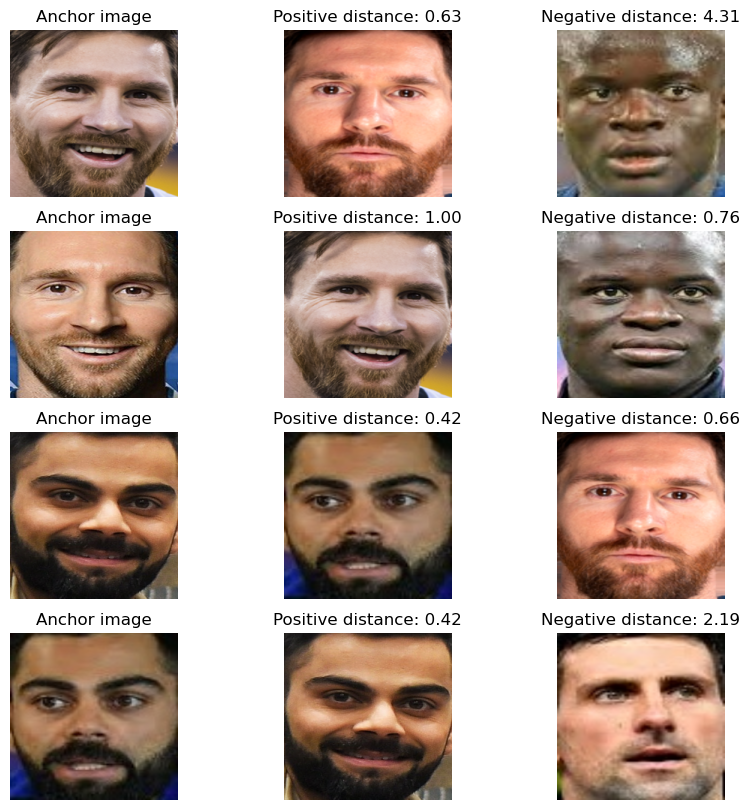

In [9]:
# create the data input pipeline for test dataset
testTripletGenerator = TripletGenerator(datasetPath=config.TEST_DATASET)
testTfDataset = tf.data.Dataset.from_generator(
    generator=testTripletGenerator.get_next_element,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.string),
    )
)
mapFunction = MapFunction(imageSize=config.IMAGE_SIZE)
testDs = (testTfDataset
    .map(mapFunction)
    .batch(4)
    .prefetch(config.AUTO)
)

# load the test data
(anchor, positive, negative) = next(iter(testDs))
(apDistance, anDistance) = siamese_model((anchor, positive, negative))
plt.figure(figsize=(10, 10))
rows = 4
for row in range(rows):
    plt.subplot(rows, 3, row * 3 + 1)
    plt.imshow(anchor[row])
    plt.axis("off")
    plt.title("Anchor image")
    plt.subplot(rows, 3, row * 3 + 2)
    plt.imshow(positive[row])
    plt.axis("off")
    plt.title(f"Positive distance: {apDistance[row]:0.2f}")
    plt.subplot(rows, 3, row * 3 + 3)
    plt.imshow(negative[row])
    plt.axis("off")
    plt.title(f"Negative distance: {anDistance[row]:0.2f}")

### Inference with the trained model

In [6]:
registered_identities = [
    ('Curry', "./dataset/cropped_test_dataset/curry/curry-01.jpg"),
    ('Kante', "./dataset/cropped_test_dataset/kante/kante-01.jpg"),
]
test_itentity = ('Curry', "./dataset/cropped_test_dataset/curry/curry-02.jpg")

In [7]:
from PIL import Image

for name, image_path in registered_identities:
    image = Image.open(image_path) 
    siamese_model.register(np.array(image), name)
    
print(siamese_model.registered_faces)

2023-04-30 20:09:03.968675: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


{'Curry': <tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[ 1.3122895 , -1.1063958 , -2.8896153 , -1.7726691 , -1.8486875 ,
        -2.8940246 ,  0.8687728 , -2.8919394 , -3.2822661 ,  2.1000023 ,
         3.2162106 , -3.1757386 ,  1.5069914 , -2.1985412 ,  4.177756  ,
        -0.06081356, -3.568319  , -0.7277431 ,  1.1514206 ,  1.1216478 ,
        -0.20956539,  4.038069  , -0.7211838 ,  1.7717315 ,  1.3387556 ,
         3.6504765 , -3.0281348 ,  5.4087815 , -0.73185974,  0.5845053 ,
        -0.8408757 ,  1.359083  ,  1.8279601 ,  0.6137449 , -0.04883429,
        -0.6745132 , -0.6619509 , -4.5164022 , -1.7160102 ,  1.7590914 ,
         2.1792495 ,  1.368087  ,  1.6416312 , -3.3836055 , -0.44573304,
        -3.2733638 , -0.10751724,  2.5407214 ,  0.9999861 , -0.6487044 ,
        -1.0242928 , -3.70094   , -0.7658131 ,  2.3424916 ,  2.1914625 ,
        -2.141696  , -0.01719033,  3.7896836 ,  2.2078872 ,  1.5470638 ,
        -0.79967415, -1.3919426 ,  4.0179353 , -3.744276  , -2.0

2023-04-30 20:09:04.999292: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [9]:
image = Image.open(test_itentity[1]) 
predicted_name = siamese_model.recognize_face(np.array(image), threshold=1.0, verbose=True)
print(predicted_name)

dist:[0.8896544], name:Curry
dist:[1.0394354], name:Kante
prediction: Curry
Curry
